# Imports

In [10]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd
import duckdb

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


pio.renderers.default = "notebook" 

# Get data

In [11]:
circuits = duckdb.sql("""SELECT * FROM 'data/*_circuit_profiles.csv'""").df()

# Track clustering

## Identifying number of clusters

In [12]:
circuits['track_id'] = circuits['event'] + ' ' + circuits['year'].astype(str)

categories = [
    'real_altitude',
    'avg_speed', 
    'top_speed', 
    'braking_events', 
    'low_pct',
    'med_pct', 
    'high_pct', 
    'slow_corners', 
    'medium_corners', 
    'fast_corners',
    'chicanes', 
    'air_temp_avg', 
    'track_temp_avg', 
    'rain_detected'
]

In [14]:
# feature matrix
X_raw = circuits[categories].values

ks = list(range(2, 11))
inertias = []
silhouettes = []

for k in ks:
    pipe = Pipeline([
        ("imputer", SimpleImputer()),             
        ("scaler", StandardScaler()),             
        ("cluster", KMeans(n_clusters=k, random_state=42))
    ])
    labels = pipe.fit_predict(X_raw)
    inertias.append(pipe.named_steps["cluster"].inertia_)
    
    # grab the scaled data to compute silhouette
    X_scaled = pipe.named_steps["scaler"].transform(
                   pipe.named_steps["imputer"].transform(X_raw)
               )
    silhouettes.append(silhouette_score(X_scaled, labels))

# pack into DataFrame
df_diag = pd.DataFrame({
    "n_clusters": ks * 2,
    "value": inertias + silhouettes,
    "metric": ["Inertia"] * len(ks) + ["Silhouette"] * len(ks)
})

# interactive Plotly facets
fig = px.line(
    df_diag,
    x="n_clusters",
    y="value",
    color="metric",
    facet_row="metric",
    markers=True,
    title="Elbow & Silhouette Diagnostics"
)

fig.update_xaxes(dtick=1)

# unlink all y-axes
fig.update_yaxes(matches=None)

# drop facet annotations
fig.for_each_annotation(lambda a: a.update(text=""))

fig.update_layout(height=600, showlegend=True)
fig.show()



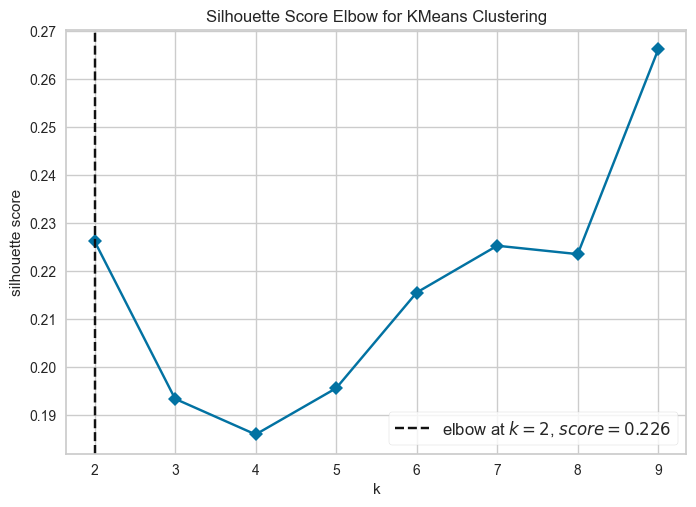

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [29]:


from yellowbrick.cluster import KElbowVisualizer

numeric_cols = circuits.select_dtypes(include='number').columns
df_clean = circuits[numeric_cols].dropna()
df_scaled = StandardScaler().fit_transform(df_clean)

# Then scale
df_scaled = StandardScaler().fit_transform(df_clean)


# Use Yellowbrick to find optimal k
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), metric='silhouette', timings=False)

visualizer.fit(df_scaled)       
visualizer.show()


In [33]:
from scipy.cluster.hierarchy import linkage
import plotly.figure_factory as ff

# Perform hierarchical clustering
linked = linkage(df_scaled, method='ward')

# Create interactive dendrogram
fig = ff.create_dendrogram(df_scaled, orientation='top', linkagefun=lambda x: linked)
fig.update_layout(title="Interactive Dendrogram (ward linkage)")
labels = df_clean.index.astype(str).tolist()
fig = ff.create_dendrogram(df_scaled, labels=labels, orientation='top', linkagefun=lambda x: linked)

fig.show()

## PCA analysis

In [34]:
track_profile, pipe = h.fit_track_clusters(
    circuits, 
    group_cols=['track_id'], 
    feat_cols=categories, 
    do_pca=True,
    clusterer=KMeans(n_clusters=6, random_state=42)
 )

circuits['cluster'] = circuits['event'].astype(str)+'_'+circuits['year'].astype(str)
circuits['cluster'] = circuits['cluster'].map(track_profile.set_index('track_id')['cluster'])

In [35]:
cluster_vals = sorted(track_profile['cluster'].unique(), key=lambda x: int(x))

fig = px.scatter(
    track_profile,
    x="PC1", y="PC2",
    color="cluster",
    hover_data="track_id",
    title=f"PCA view for k={len(cluster_vals)}",
    category_orders={"cluster": cluster_vals}
)
fig.show()

In [36]:
cluster_stats = track_profile.groupby('cluster')[categories].mean()
feature_spreads = cluster_stats.max() - cluster_stats.min()
print(feature_spreads.sort_values(ascending=False))

real_altitude     231.222222
avg_speed          86.284730
top_speed          48.333333
track_temp_avg     15.807363
air_temp_avg       12.633938
fast_corners       11.366667
chicanes            6.960000
slow_corners        6.920000
medium_corners      3.566667
braking_events      3.020000
high_pct            0.452957
rain_detected       0.400000
low_pct             0.266581
med_pct             0.186376
dtype: float64


In [37]:
top8 = feature_spreads.sort_values(ascending=False).head(8).index.tolist()
h.plot_cluster_radar(track_profile, top8, cluster_col='cluster', normalize=True)

# 🧪 2. Predictive Power of FP1-2-3 for Q & R

# 🔄 3. Heatmaps per Cluster